In [1]:
drive = True  # False for Local
if drive:
    !pip install torch==1.11.0
    !pip install pretty_midi
    !pip install sparsemax
    
# locally, also compile torch with CUDA enabled:
# conda install pytorch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 cudatoolkit=11.3 -c pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.11.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.11.0 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.11.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi
#this package is used to write it back into music.
from mido import Message, MidiFile, MidiTrack
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import random
import torch.distributions
import sparsemax

In [3]:
if drive:
    from google.colab import drive
    drive.mount('/content/drive')
    my_drive_path = #DRIVE PATH HERE
else: # local
    my_drive_path = "./"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# load the data; in these small-scale tests I usually loaded the val data because it didn't take as long to load. When you are training, load the train data.
data = torch.load(my_drive_path + "usable_data/mar-1-variable_bin_bounds_val.csv")  # truncate rather than padding w/ silence
# data = torch.load(my_drive_path + "usable_data/train_tempo_all_w_beats_30.csv")  # pad w/ silence at the end
# data = torch.load(my_drive_path + "usable_data/validationn_tempo_round_down_30.csv")  # load val data for small-scale tests
torch.manual_seed(2022)

In [5]:
#this function takes in the piece of music and returns the chroma vectors
def get_chroma(roll, length):
    chroma_matrix = torch.zeros((roll.size()[0],12))
    for note in range(0, 12):
        chroma_matrix[:, note] = torch.sum(roll[:, note::12], axis=1)
    return chroma_matrix

In [6]:
#this takes in the sequence and creates a self-similarity matrix (it calls chroma function inside)
def SSM(sequence):
  #tensor will be in form length, hidden_size (128)
  cos = nn.CosineSimilarity(dim=1)
  chrom = get_chroma(sequence, sequence.size()[0])
  len = chrom.size()[0]
  SSM=torch.zeros((len, len))
  for i in range(0, len):
    SSM[i] = cos(chrom[i].view(1, -1),chrom)
  return (SSM)

In [7]:
#this bundles the SSM function.
def batch_SSM(seq, batch_size):
  # takes sequence in format
  # [beats=400, batch_size, 128]
  # print("SSM\tsequence_shape", seq.shape)
  SSMs = []
  for i in range(0, batch_size):
    # print("SSM\tsequence", seq[:,i,:].shape)
    ssm = SSM(seq[:,i,:])  # [beats, batch, 128]
    # print("SSM\tssm", ssm.shape)
    SSMs.append(ssm)  
  return torch.vstack(SSMs)

In [8]:
# Takes in the batch size and data and returns batches of the batch size
def make_batches(data, batch_size, piece_size=800):
  random.shuffle(data)
  batches = []
  if batch_size > 1:  # make batches
    num_batches = len(data)//batch_size
    for i in range(0, num_batches):
      batch = torch.cat(list(np.array(data)[i*batch_size: (i+1)*(batch_size)][:, 0])).view(batch_size, piece_size, 128)
      batches.append(batch)
  else:  # each piece is its own batch - doesn't use passed-in piece_size
    for i in range(len(data)):
      # removes tempo info from data, but leaves 1 piece per batch
      piece_size = data[i][0].shape[0]
      batch = data[i][0].view(1, piece_size, 128)
      batches.append(batch)
      # print(batches[i])
  # print(batches)
  return batches

In [9]:
# returns batches where piece size is constant within the batch
# but piece size is different across batches
# and batches are in random order
def make_variable_size_batches(data, min_batch_size=10):
  # sort data by num beats (element at index 2 in each sublist)
  data.sort(key = lambda x: x[2], reverse=False)  # sort descending

  # split data into batches, where each batch contains pieces of the same size
  batches = []

  i = 0  # counter of pieces
  
  while i < len(data):
    this_batch = []
    pieces_this_batch = 0
    current_beats = data[i][2] # num beats in this batch

    # for all pieces with this # of beats
    while i < len(data) and data[i][2] == current_beats:
      # get tensor from row of data, and reshape 
      just_tensor = data[i][0].view(1, data[i][0].shape[0], 128)  
      this_batch.append(just_tensor)

      # increment counters
      i += 1
      pieces_this_batch += 1

    # print("this batch", this_batch)
    # print("shapes in batch")
    # for p in this_batch:
      # print("\t", p.shape)
        
    # only save large enough batches
    if pieces_this_batch >= min_batch_size:
        # reformat pieces in this batch into one tensor of size [batch size, beats, 128]
        batch = torch.cat(this_batch, dim=0)

        # store batch
        batches.append(batch)

    # clean up variables
    del this_batch
    del pieces_this_batch
    del current_beats

  # randomize batches order
  random.shuffle(batches)

  return batches

In [10]:
#sampling function 
def topk_sample_one(sequence, k):
  #takes in size sequence length, batch size, values
  softmax = sparsemax.Sparsemax(dim=2)
  vals, indices = torch.topk(sequence[:, :, 30:98],k)
  indices+=30
  seq = torch.distributions.Categorical(softmax(vals.float()))
  samples = seq.sample()
  onehot = F.one_hot(torch.gather(indices, -1, samples.unsqueeze(-1)), num_classes = sequence.shape[2]).squeeze(dim=2)
  return(onehot)

In [11]:
#samples multiple times for the time-step
def topk_batch_sample(sequence, k):
  for i in range(0, 3):
    new= topk_sample_one(sequence, k)
    if i ==0:
      sum = new
    else:
      sum+=new
  return(torch.where(sum>0, 1, 0))

In [12]:
def custom_loss(output, target):
  #custom loss function
  criterion = nn.BCEWithLogitsLoss()
  weighted_mse = criterion(output.double(), target.double())
  batch_size = output.size()[1]
  ssm_err = 0
  for i in range(0, batch_size):
    SSM1 = SSM(output[:,i,:])
    SSM2 = SSM(target[:,i,:])
    ssm_err += (torch.sum((SSM1-SSM2)**2)/(SSM2.size(0)**2))


  return torch.sum(weighted_mse)+ssm_err

In [13]:
# this is the model
class music_generator(nn.Module):
    def __init__(self, hidden_size, output_size, base_lstm=False):
        super().__init__()
        self.hidden_size = hidden_size  # 128
        # output_size is num expected features (128)
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers=1, bidirectional=False)
        self.attention = nn.Linear(2, 1)
        self.softmax = sparsemax.Sparsemax(dim=1)
        self.sigmoid = nn.Sigmoid()
        self.hidden = None
        self.base_lstm = base_lstm  # true to use lstm without attention

    def init_hidden(self, batch_size):
        # set hidden state to zeros after each batch
        hidden = (torch.zeros(1, batch_size, self.hidden_size)).float().to(device)  # [layers, batch_size, hidden_size/features]
    
        self.hidden = (hidden, hidden) # hidden_state, cell_state
        return

    def set_random_hidden(self, batch_size):
        # create new random hidden layer
        hidden = (torch.randn(1, batch_size, self.hidden_size)).float().to(device)
        self.hidden = (hidden, hidden)
        return

    def forward(self, in_put, batch_size, prev_sequence, batched_ssm):
        # look at tensor things - view vs. reshape vs. permute, and unsqueeze and squeeze
        # try looking at the LSTM equations
        # .to('cpu')  # returns a copy of the tensor in CPU memory
        # .to('cuda:0')  # returns copy in CUDA memory, 0 indicates first GPU device
        # https://pytorch.org/docs/stable/tensors.html#torch.Tensor.to

        # sequence length
        # size of input (10 or 1)
        sequence_length = in_put.size()[0]
        # print("in_put:", in_put.shape)

        # Run the LSTM
        # output - sequence of all the hidden states
        # hidden - most recent hidden state
        # input dimensions: [sequence_length, batch_size, 128]
        output, self.hidden = self.lstm(in_put.float().to(device), self.hidden)
        # output dimensions: [sequence_length, batch_size, 128]
        # outputs as many beats (sequence_length) as there were beats in the input
        # hidden: last hidden states from last beat

        #########################
        # attention starts here #
        #########################
        
        # output without attention
        avg_output = output.view(sequence_length, batch_size, 128)  # reshape
        
        # if we're using a starter sequence, cut output to last note
        avg_output = avg_output[-1,:,:].unsqueeze(1)  # [batch_size, 1, 128]
        
        # return early (w/o attention) for base lstm
        if self.base_lstm:
          return avg_output.transpose(0,1), self.hidden
        
        #this variable holds the output after the attention has been applied.
        seqs = []

        # slice the batched ssms to the right places
        beat_num = prev_sequence.shape[0]
        
        # find the row for this beat in each ssm
        # batched_ssm shape is (batch_size*beats, beats), bc all the pieces are stacked vertically atop each other
        inds_across_pieces = range(beat_num, batched_ssm.shape[0], batched_ssm.shape[1])  # eg 11, 2625, 105 - indices of this beat in each of the pieces in the batched_ssm
        # for the row for this beat in each ssm, slice the row up to (not including) this beat
        ssm_slice = batched_ssm[inds_across_pieces, :beat_num] # [batch_size, beat_num]
        # sparsemax makes entries in the vector add to 1
        weights = self.softmax(ssm_slice)  # weights are shape [batch_size, beat_num]

        # this is the sparsemaxed SSM multiplied by the entire previous sequence
        # to scale the previous timesteps for how much attention to pay to each
        # TODO: replace .T
        weighted = (prev_sequence.permute(2,1,0)*weights).T  # [beat_num, batch_size, 128]

        # then it's summed to provide weights for each note.
        weight_vec = (torch.sum(weighted, axis=0)).unsqueeze(1).to(device)  # [batch_size, 1, 128]

        # This concatenates the weights for each note with the output for that note, which is then run through the linear layer to get the final output.
        # returns attentioned note
        pt2 = torch.hstack((weight_vec, avg_output)).transpose(1,2)
        attentioned = self.attention(pt2.float()).permute(2,0,1)  # before .permute() .to("cuda:0")).to('cpu')

        # delete vars to remove clutter in memory
        del pt2
        del weight_vec
        del weighted
        del weights
        del ssm_slice
        del inds_across_pieces
        del beat_num
        del avg_output

        # return attentioned note
        return attentioned.double(), self.hidden  # hidden = hidden_state, cell_state

In [14]:
class model_trainer():
  def __init__(self, generator, optimizer, data, hidden_size=128, batch_size=50):
    self.generator = generator
    self.optimizer = optimizer
    self.batch_size = batch_size  # play with this
    self.hidden_size = hidden_size  # 128
    self.data = data
    self.data_length = data[0][0].shape[0]  # as long as piece length doesn't vary
  def to(self, device):
     self.generator = self.generator.to(device)
  def train_epochs(self, num_epochs=50, full_training=False, variable_size_batches=False, save_name="model"):
    #trains each epoch
    losslist = []
    #useful when you want to see the progression of the SSM over time
    piclist = []

    for iter in tqdm(range(0, num_epochs)):
      # start training the generator
      self.generator.train()
      # use all data, and group batches by piece size
      batches = make_variable_size_batches(self.data, 1)
      

      cum_loss = 0
      for batch_num in tqdm(range(len(batches))):
        batch = batches[batch_num]
        if full_training:
          # train on full-length pieces
          loss = self.train(batch)
        else:
          # train on first 105 beats of each piece
          loss = self.train(batch[:,:105,:])  # [batch, beats, 128]
        cum_loss+=loss
        del batch
        del loss
      del batches
          
      # print loss for early stopping
      print(cum_loss)
    
      # save generator after each epoch
      curr_file = f"/exp/shager/music-gen/models/{save_name}-epoch-{str(iter)}-loss-{cum_loss:.5f}.txt"
      # !touch curr_file
      torch.save(self.generator, curr_file)

      # generate example piece for piclist
      #snap = self.generate_n_examples(n=1, length=95, starter_notes=10)

      losslist.append(cum_loss) 
      #piclist.append(snap)
        
      # early stopping:
      # after each epoch,
      # run w/ validation
      # if devset (validation) loss goes up for ~5 epochs in a row, early stopping
    return losslist, piclist

  # train for one batch
  def train(self, batch, starter_notes=10):
    # seed vectors for the beginning:
    batch_size = batch.shape[0]
    self_sim = batch_SSM(batch.transpose(0,1), batch_size)  # use variable batch size
    sequence = batch[:,0:starter_notes,:].transpose(0,1)  # start w/ some amount of the piece - 10 might be a bit much
    generated = batch[:,0:starter_notes,:].transpose(0,1)

    # reset hidden to zeros for each batch
    self.generator.init_hidden(batch_size)
        
    # zero the gradients before training for each batch
    self.optimizer.zero_grad()
    
    # for accumulating loss
    loss = 0

    # first .forward on sequence of num_starter_beats (~5 or 10 or so)
    # then loop from there to generate one more element
    next_element = sequence.to("cpu")  # make copy!

    # take
    for i in range(0,batch.shape[1]-starter_notes):  # for each beat
      # iterate through beats, generating for each piece in the batch as you go
      val = torch.rand(1)  # probability it uses original - teacher forcing

      # generate a beat for each piece in the batch
      # we need to do this even in cases of teacher forcing, so we can calculate loss
      output, _ = self.generator.forward(next_element, batch_size, sequence, self_sim)  # returns output, hidden - we don't need the latest copy of hidden
      # print("outside output:", output.shape)
        
      if (val > .8):
        # teacher forcing - 20% of the time,  use original from piece instead of output
        next_element = batch[:,i+1,:].unsqueeze(0)  # [1, 0/deleted, 128] to [1, 1, 128]
      else:
        # 80% of the time we keep the output
        # take last output for each batch
        next_element = topk_batch_sample(output, 20) # sample up to 5 most likely notes at this beat
      
      # add next_element (either generated or teacher) to sequence
      sequence = torch.vstack((sequence, next_element.to("cpu"))) # .unsqueeze(0)
      # append output (generated - not teacher forced) for loss
      generated = torch.vstack((generated, output.to('cpu')))  # used for loss
    
    # run loss after training on whole length of the pieces in the batches
    single_loss = custom_loss(generated[starter_notes:,:,:], batch.transpose(0,1)[starter_notes:,:,:])
    single_loss.backward()

    # update the parameters of the LSTM after running on full batch
    self.optimizer.step()

    loss += single_loss.detach().to('cpu')
    del next_element
    del self_sim
    del sequence
    del generated
    del single_loss
    return (loss)

  def generate_n_pieces(self, initial_vectors, n_pieces, length, batched_ssm):
    # generates a batch of n new pieces of music

    # freeze generator so it doesn't train anymore
    self.generator.eval().to(device)
    # start generator on random hidden states and cell states
    self.generator.set_random_hidden(n_pieces)
  
    # initial vectors in format [batch_size, num_notes=10, 128]
    # change sequence to [10, batch_size, 128]
    sequence = initial_vectors.transpose(0,1).to(device)
    next_element = sequence.to(device)

    # can't generate more notes than the ssm has entries
    max_notes = batched_ssm.shape[0]-sequence.shape[0]
    
    # generate [length] more beats for the piece
    # or as many beats as available in the ssm
    for i in range(min(length, max_notes)):  # one at a time
      with torch.no_grad():
        # use n_pieces to generate as the batch size
        output, _ = self.generator.forward(next_element.float().to(device), n_pieces, sequence.to(device), batched_ssm.to(device))
        next_element = topk_batch_sample(output, 50)  # sample up to 5 most likely notes at this beat
      # add element to sequence
      sequence = torch.vstack((sequence, next_element.to(device)))

    # return sequence of beats
    return sequence.to("cpu")

  def generate_n_examples(self, n=1, length=390, starter_notes=10, piece_inds=[0], random_source_pieces=False, batched_ssms=None):
    # get pieces from the data
    pieces = torch.vstack([self.data[i][0].unsqueeze(0) for i in piece_inds]) # get just the note for each piece, and stack pieces
    
    # print(pieces.shape)

    # take first 10 notes in format [1, 10, 128]
    first_vecs = pieces[:,0:starter_notes,:]

    # create batched SSMs for each piece
    if batched_ssms==None:
      batched_ssms = batch_SSM(pieces.transpose(0,1), n)

    # generate pieces
    new_gen = self.generate_n_pieces(first_vecs, n, length, batched_ssms)

    # clean up variables
    del pieces
    del first_vecs
    del batched_ssms

    # return pieces
    return new_gen

In [15]:
data = torch.load(my_drive_path + "usable_data/mar-1-variable_bin_bounds_test.csv")

In [28]:
path = "/content/drive/MyDrive/Music-gen 2023/test_sets/examples/"

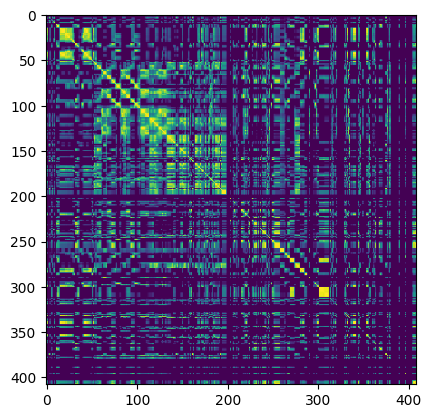

In [306]:
example = data[88]
plt.imshow(SSM(example[0][:]))
plt.savefig(path+"example_original.png")

In [307]:
best_model_att = torch.load(my_drive_path+"trained/3-16-best-models/best-attention-model.txt", map_location=torch.device('cpu'))
optimizer_att = None
hidden_size = 128
trainer_att = model_trainer(best_model_att, optimizer_att, [example], hidden_size)
device = "cpu"

In [308]:
example_att = trainer_att.generate_n_examples(n=1, length=len(example[0]), starter_notes=10, piece_inds=[0]).squeeze()

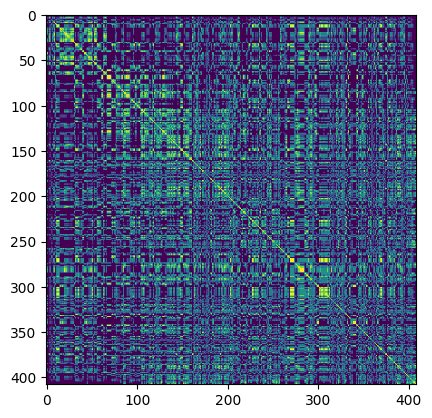

In [309]:
plt.imshow(SSM(example_att))
plt.savefig(path+"example_attention.png")

In [310]:
new_roll_final = np.vstack((example_att.squeeze(), np.zeros(128)))
midi = MidiFile(type = 1)
midi.tracks.append(MidiTrack(roll_to_track(new_roll_final, example[1])))
midi.save(path+"attention.midi")

In [302]:
best_model_base = torch.load(my_drive_path+"trained/3-16-best-models/best-basic-model.txt", map_location=torch.device('cpu'))
optimizer_base = None
hidden_size = 128
trainer_base = model_trainer(best_model_base, optimizer_base, [example], hidden_size)
device = "cpu"

In [303]:
example_base= trainer_base.generate_n_examples(n=1, length=len(example[0]), starter_notes=10, piece_inds=[0]).squeeze()

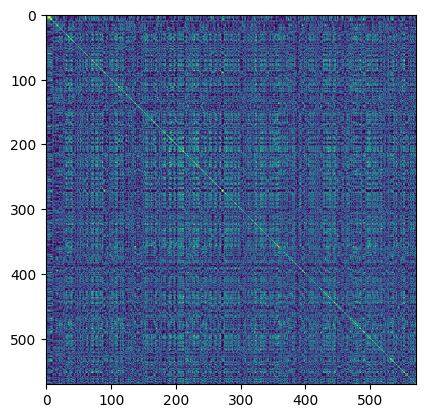

In [304]:
plt.imshow(SSM(example_base))
plt.savefig(path+"example_basic.png")

In [305]:
new_roll_final = np.vstack((example_base.squeeze(), np.zeros(128)))
midi = MidiFile(type = 1)
midi.tracks.append(MidiTrack(roll_to_track(new_roll_final, example[1])))
midi.save(path+"basic.midi")

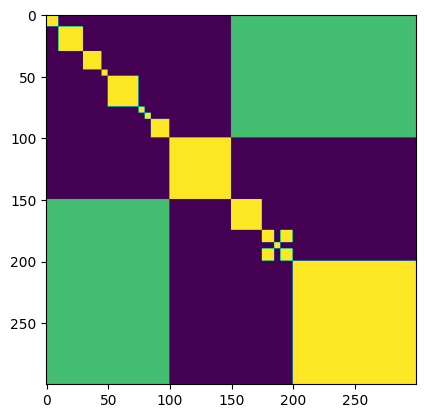

In [ ]:
N=300
A = torch.zeros(N, N)
A[:10, :10]=1
A[10:30, 10:30]=1
A[30:45, 30:45]=1
A[45:50, 45:50]=1
A[50:75, 50:75]=1
A[75:80, 75:80]=1
A[80:85, 80:85]=1
A[85:100, 85:100]=1
A[0:100, 150:300]=0.7
A[150:300,0:100]=0.7
A[100:150, 100:150]=1
A[150:175, 150:175]=1
A[175:185, 175:185]=1
A[185:190, 185:190]=1
A[175:185, 190:200]=1
A[ 190:200, 175:185]=1
A[190:200, 190:200]=1
A[200:300, 200:300]=1

plt.imshow(A)
#plt.savefig(path+"synthetic_original.png")

In [ ]:
best_model_base = torch.load(my_drive_path+"trained/3-16-best-models/best-basic-model.txt", map_location=torch.device('cpu'))
optimizer_lstm = None
hidden_size = 128
trainer_base = model_trainer(best_model_base, optimizer_lstm, [example], hidden_size)
device = "cpu"

In [ ]:
example_att = trainer_att.generate_n_examples(n=1, length=len(example[0]), starter_notes=10, piece_inds=[0], batched_ssms=A).squeeze()


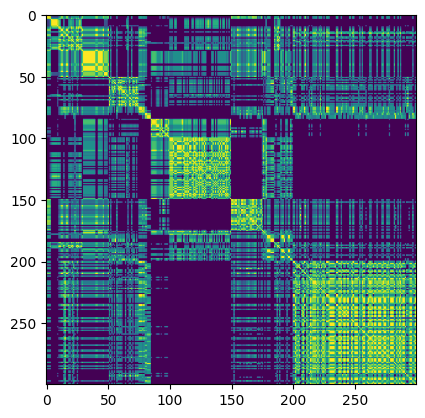

In [ ]:
plt.imshow(SSM(example_att[:]))
#plt.savefig(path+"synthetic_att.png")

In [ ]:
example_base = trainer_base.generate_n_examples(n=1, length=len(example[0]), starter_notes=10, piece_inds=[0],batched_ssms=A).squeeze()

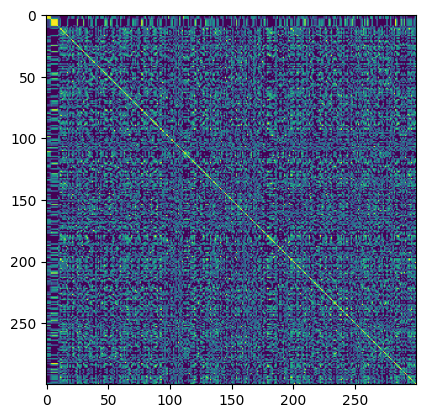

In [ ]:
plt.imshow(SSM(example_base))
#plt.savefig(path+"synthetic_base.png")

In [25]:
def stop_note(note, time):
    return Message('note_off', note = note,
                   velocity = 0, time = time)

def start_note(note, time):
    return Message('note_on', note = note,
                   velocity = 120, time = time)

def roll_to_track(roll, tempo):
    delta = 0

    
    # MIDI note for first column.
    midi_base = 0
    notes = [0] * len(roll[0])
    for row in roll:
        for i, col in enumerate(row):
            note = i
            if col>notes[i] and col!=0: 
                if notes[i]!=0:
                    yield stop_note(note, delta)
                    delta = 0
                yield start_note(i, delta)
                delta = 0
                notes[i] = note
            elif col == 0:
                if notes[i]!=0:
                    # Stop the ringing note
                    yield stop_note(note, delta)
                    delta = 0
                notes[i] = 0
        # ms per row
        delta += int(np.round((1/(tempo/60))*1000))

In [ ]:
new_roll_final = np.vstack((example_att.squeeze(), np.zeros(128)))
midi = MidiFile(type = 1)
midi.tracks.append(MidiTrack(roll_to_track(new_roll_final, example[1])))
midi.save('/content/drive/MyDrive/Music-gen 2023/blank.midi')

In [ ]:
g = np.vstack((example[0], np.zeros(128)))
midi = MidiFile(type = 1)
midi.tracks.append(MidiTrack(roll_to_track(g, example[1])))
midi.save('/content/drive/MyDrive/Music-gen 2023/blank.midi')

In [ ]:
def random_noise(original, length, starter_notes):
  g = torch.ones(1, length, 128)
  g = g/128
  return torch.vstack([original[0][:starter_notes],topk_batch_sample(g,50)[0]])


In [ ]:
def make_deliverables(data, att_model, base_model, num_to_save, path, length):
  g = range(len(data))
  piece_indices = random.sample(g, num_to_save)
  for piece_index in piece_indices:
    path_beginning = path+"_"+str(piece_index)
    #find original piece
    piece = data[piece_index]
    
    #GENERATE ROLL
    #attention
    trainer_att = model_trainer(att_model, None, [piece], 128)
    example_att = trainer_att.generate_n_examples(n=1, length=length-10, starter_notes=10, piece_inds=[0]).squeeze()

    #base
    trainer_base = model_trainer(base_model, None, [piece], 128)
    example_base = trainer_base.generate_n_examples(n=1, length=length-10, starter_notes=10, piece_inds=[0]).squeeze()

    #random
    example_rand = random_noise(piece, length-10, 10)

    #GENERATE PLOTS
    #original
    plt.imshow(SSM(piece[0][:length]))
    plt.savefig(path+"plots/"+str(piece_index)+"_original.png")

    #attention
    plt.imshow(SSM(example_att))
    plt.savefig(path+"plots/"+str(piece_index)+"_attention.png")

    #base
    plt.imshow(SSM(example_base))
    plt.savefig(path+"plots/"+str(piece_index)+"_lstm.png")

    #random
    plt.imshow(SSM(example_rand))
    plt.savefig(path+"plots/"+str(piece_index)+"_random.png")

    #GENERATE MUSIC
    #original
    g = np.vstack((piece[0][:length], np.zeros(128)))
    midi = MidiFile(type = 1)
    midi.tracks.append(MidiTrack(roll_to_track(g, piece[1])))
    midi.save(path+"music/"+str(piece_index)+"_original.midi")

    #attention
    new_roll_final = np.vstack((example_att.squeeze(), np.zeros(128)))
    midi = MidiFile(type = 1)
    midi.tracks.append(MidiTrack(roll_to_track(new_roll_final, piece[1])))
    midi.save(path+"music/"+str(piece_index)+"_attention.midi")

    #base
    new_roll_final = np.vstack((example_base.squeeze(), np.zeros(128)))
    midi = MidiFile(type = 1)
    midi.tracks.append(MidiTrack(roll_to_track(new_roll_final, piece[1])))
    midi.save(path+"music/"+str(piece_index)+"_lstm.midi")

    #random
    new_roll_final = np.vstack((example_rand.squeeze(), np.zeros(128)))
    midi = MidiFile(type = 1)
    midi.tracks.append(MidiTrack(roll_to_track(new_roll_final, piece[1])))
    midi.save(path+"music/"+str(piece_index)+"_random.midi")
    





In [ ]:
test_data = torch.load(my_drive_path + "usable_data/mar-1-variable_bin_bounds_test.csv")

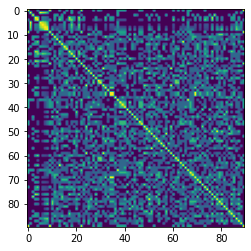

In [ ]:
make_deliverables(test_data, best_model_att, best_model_base, 8, '/content/drive/MyDrive/Music-gen 2023/test_sets/', 90)